# Processing Mass Spectrometry Imaging (MSI) data
In chapter 2 we looked at how to process spectra and put them into a nicely aligned feature table. In chapter 3 we saw what information we can get from images. In this chapter, we will combine both by supplementing image information to the feature table. As usual, we will start with setting up a project. We will make use of a Spectra save that I created in advance as this would take too long and you would need the original quite large data file. It only contains three target compounds: the two alkenones C37:2 & C37:3 and pyropheophorbide a (all with a Na+ adduct)

In [1]:
from user_params import copy_checkpoint
copy_checkpoint(4)

copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\SampleImageHandlerMSI.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\SampleImageHandlerMSI.pickle
copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\ImageSample.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\ImageSample.pickle
copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\ImageROI.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\ImageROI.pickle
copied C:\Users\Yannick Zander\Downloads\maspim workshop\checkpoints\full example\ImageClassified.pickle to C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example\ImageClassified.pickle


In [2]:
%matplotlib inline

from maspim import get_project
from user_params import path_folder_real_data

project = get_project(is_MSI=True, path_folder=path_folder_real_data)

# fetch the saved spectra file
project.require_spectra(tag='targeted')


# fetch the saved image classes
project.require_images()

# set an MSI instance using spectra
project.require_data_object()

# to save memory, we can clear the spectra class now
project.forget('spectra')

# check that we got the msi object
print(project.data_object)

C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


mis_file: full example.mis
path_folder: C:\Users\Yannick Zander\Downloads\maspim workshop\data\full example
d_folder: full example.d
_distance_pixels: 100.0
_feature_table: Pandas DataFrame with columns [553.5319, 551.5162, 557.2523, tic_window, R, x, y], indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...] and shape (17118, 7)


## Adding photo

Now we will use the image classes to map the photo information to the data. Firstly, the `SampleImageHandlerMSI` defines a mapping between photo and data pixels that we will use to add `x_ROI` and `y_ROI` images. Those will be used to search pixel values in the images

In [3]:
project.add_pixels_ROI()

Now we can add the photo and plot it. Hopefully the image should be the area inside the red rectangle from the previous chapter.

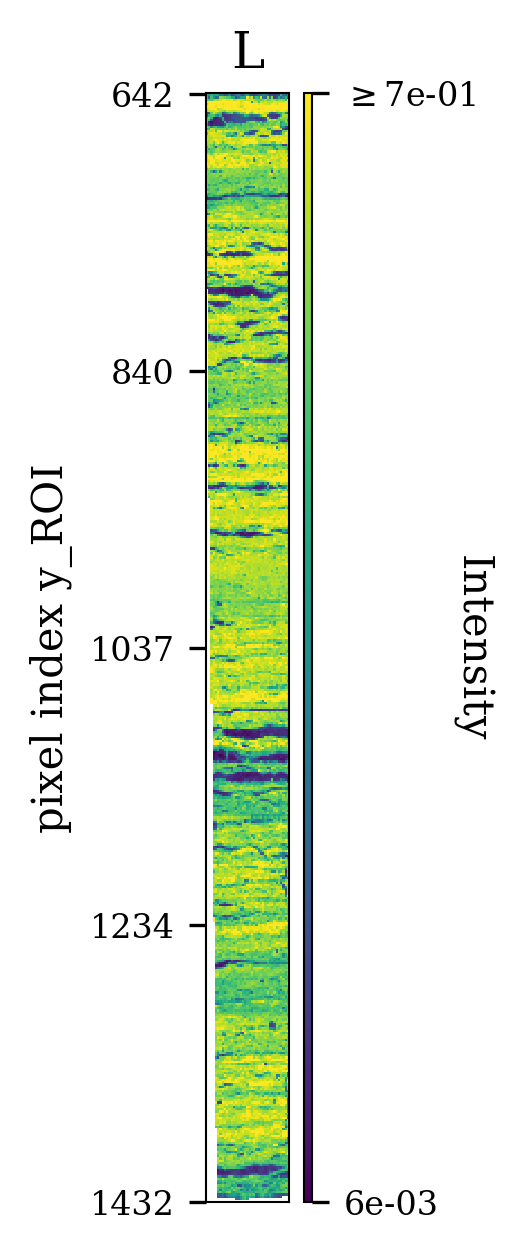

In [4]:
project.add_photo()
project.plot_comp('L', flip=True)

## Adding classifications
We can also add information about holes, light/dark pixels (from `ImageROI`) 

In [5]:
project.add_holes()
project.add_light_dark_classification()

## Plotting ion images
We can use the plot function to ignore hole pixels now:

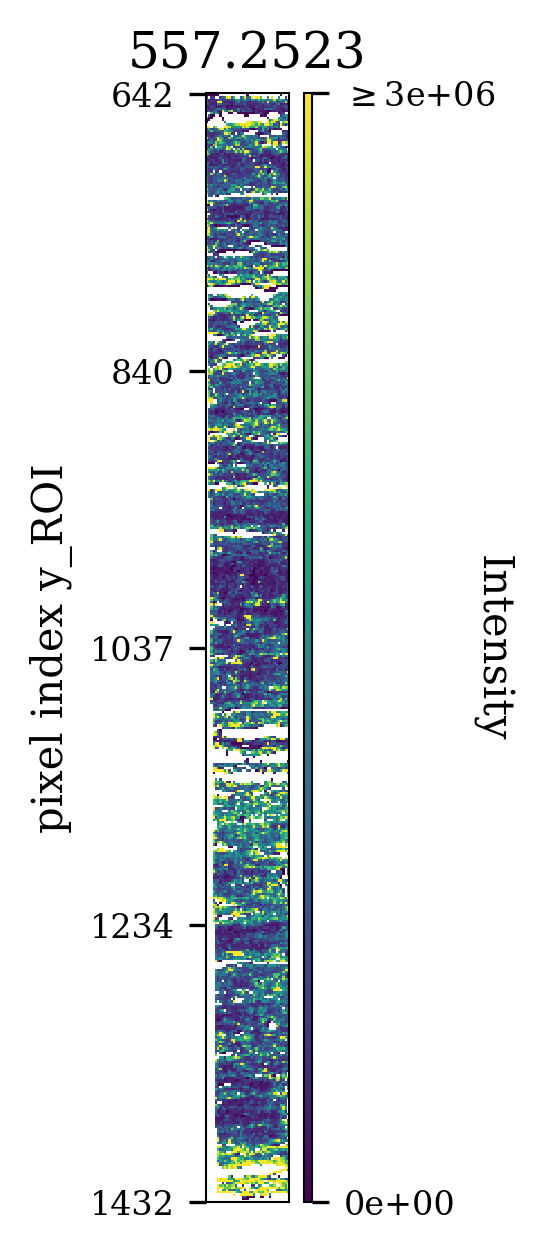

In [6]:
from maspim.res.compound_masses import mass_pyropheophorbide_a_Na_p

project.plot_comp(mass_pyropheophorbide_a_Na_p, flip=True, classification_column='valid')

Or let's be extra fancy and plot it with the image as background

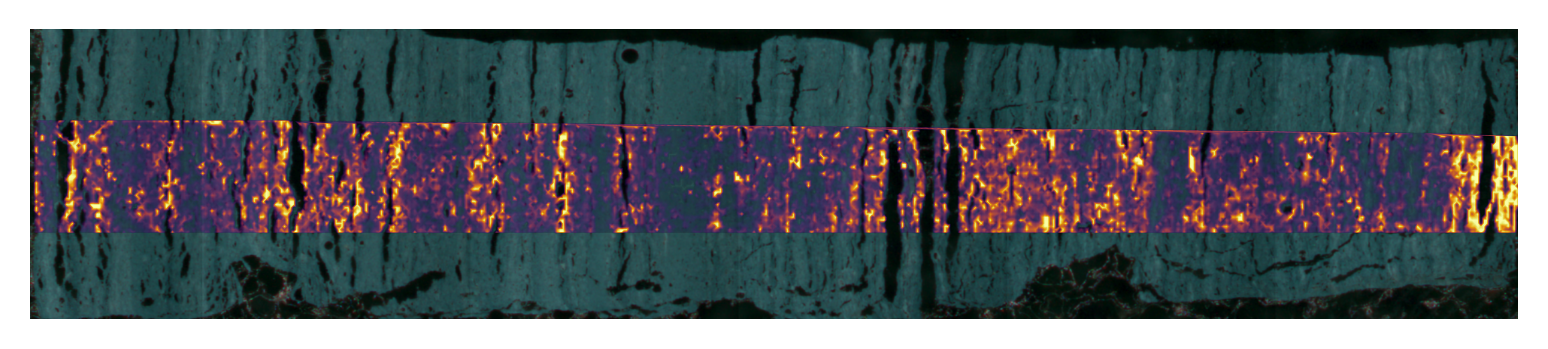

In [7]:
project.plot_comp(mass_pyropheophorbide_a_Na_p, plot_on_background=True)

## Adding laminae classification

If we want to add the laminae classification, we must first transform our data according to the tilt correction from chapter 3. 

In [8]:
if not project.corrected_tilt:  
    # this will only run the first time you execute the cell because we don't want to apply the tilt correction twice
    project.data_object_apply_tilt_correction()
project.add_laminae_classification()

warping ion images: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 644.23it/s]


## X-Ray

Finally, we can also add the X-Ray. Usually the X-ray image has to be processed a bit as well to
* remove the plastic liner (bars at top and bottom)
* remove slight rotations
* find the region corresponding to the MSI region
* apply a tilt correction  

In [9]:
import user_params
project.set_depth_span((490, 495))
project.require_xray(path_image_file=user_params.path_xray_long, 
                     depth_section=(480, 510), 
                     plts=True, 
                     overwrite=False)

obj_color: dark
_hw: [722, 2377]
_image: Numpy array of type uint8, with shape (722, 2377, 3)
path_folder: C:\Users\Yannick Zander\Downloads\maspim workshop\data\X-ray
age_span: None

### Quiz
Is the core in the first image rotated (yes/no)?

In [10]:
from tasks import chapter4_task1

chapter4_task1.ask()

### Quiz
What do you think, how large is the angle?

In [11]:
from tasks import chapter4_task2

chapter4_task2.options()
chapter4_task2.ask()

The following options are available (you can enter the number of the answer):
(1) <1 degree
(2) >= 1 but <5
(3) >5 but < 10
(4) >10


In [12]:
import math
project._xray_long._angle

-0.24854278564453125

We should now have an xray object of the right section

Punchholes not set with required parameter 'remove_gelatine', this may affect performance.
No age span specified, falling back to more general method
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\skimage\util\dtype.py:576: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.67it/s]


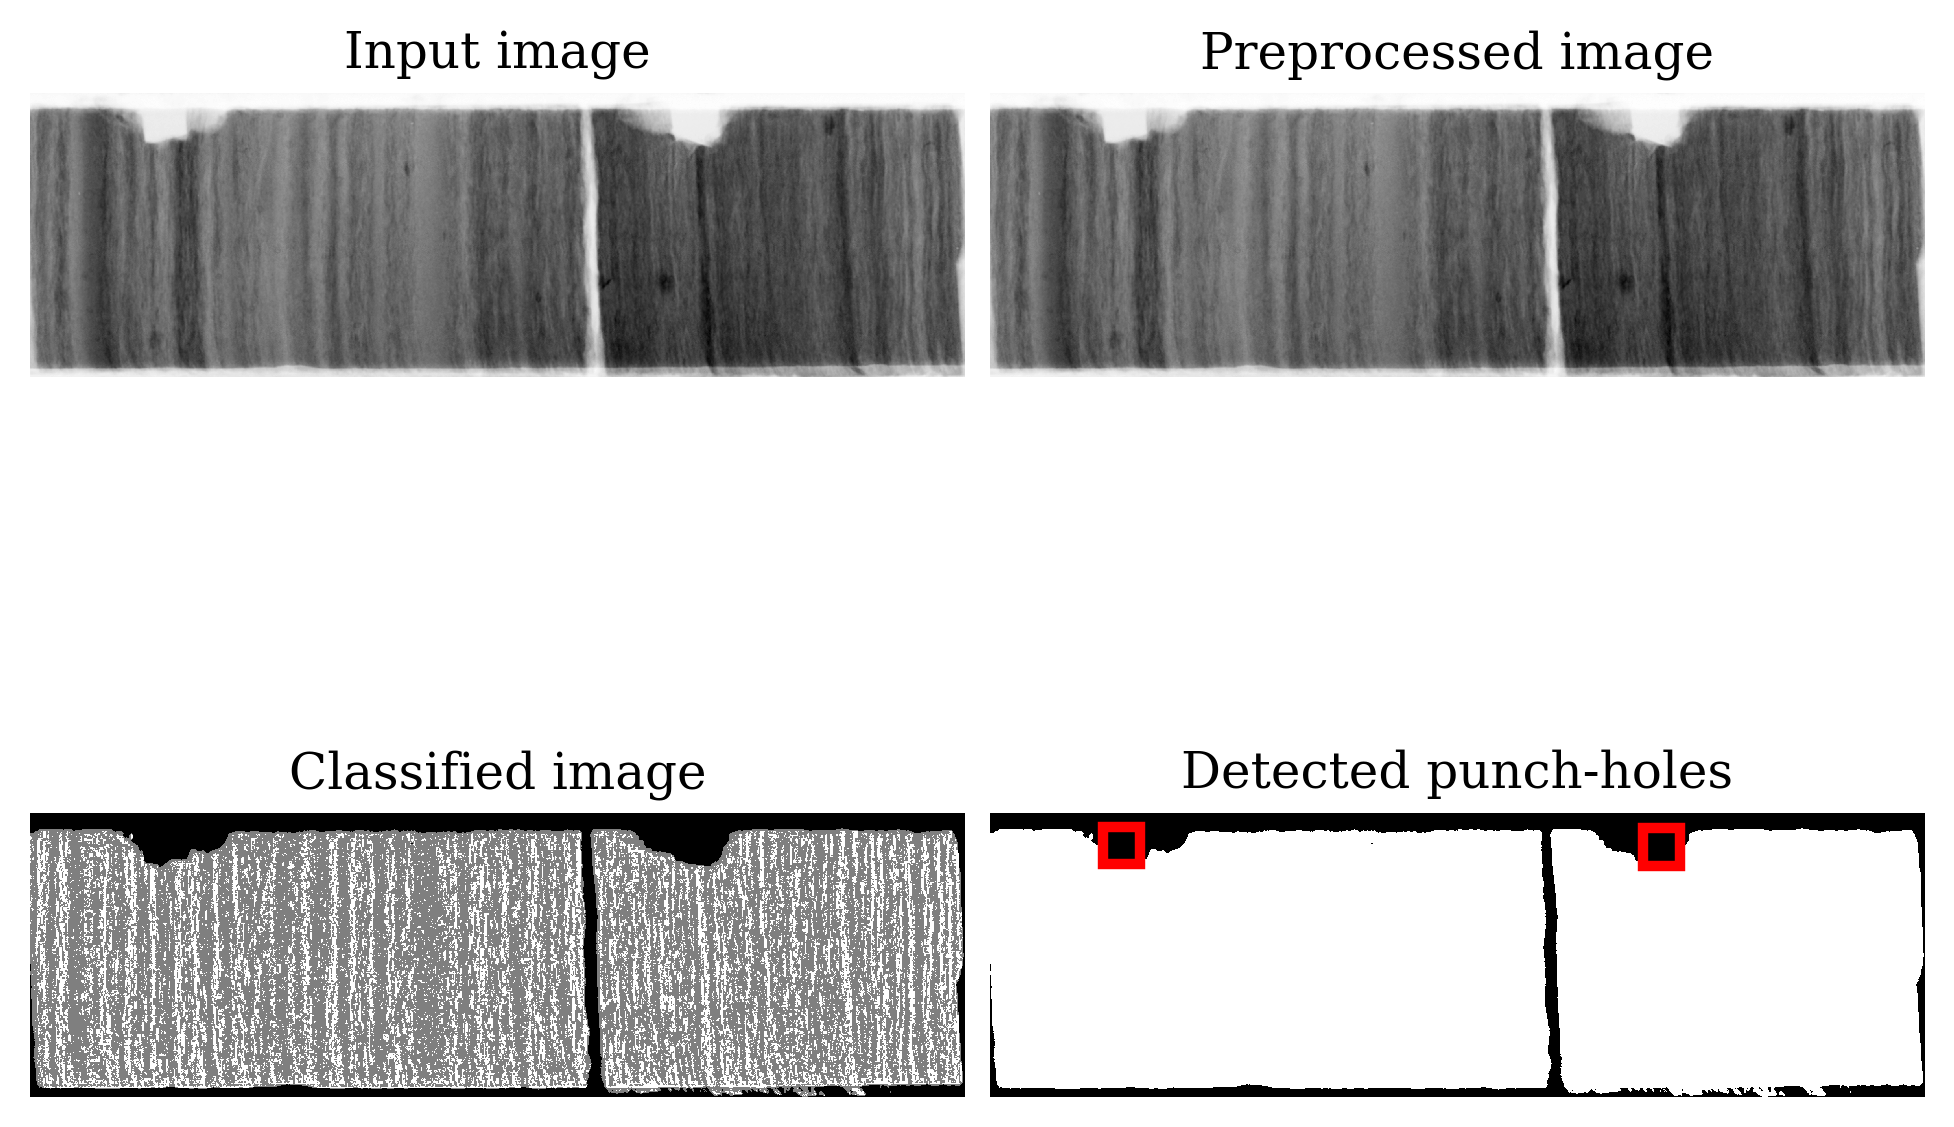

In [13]:
project.xray.plot_overview()

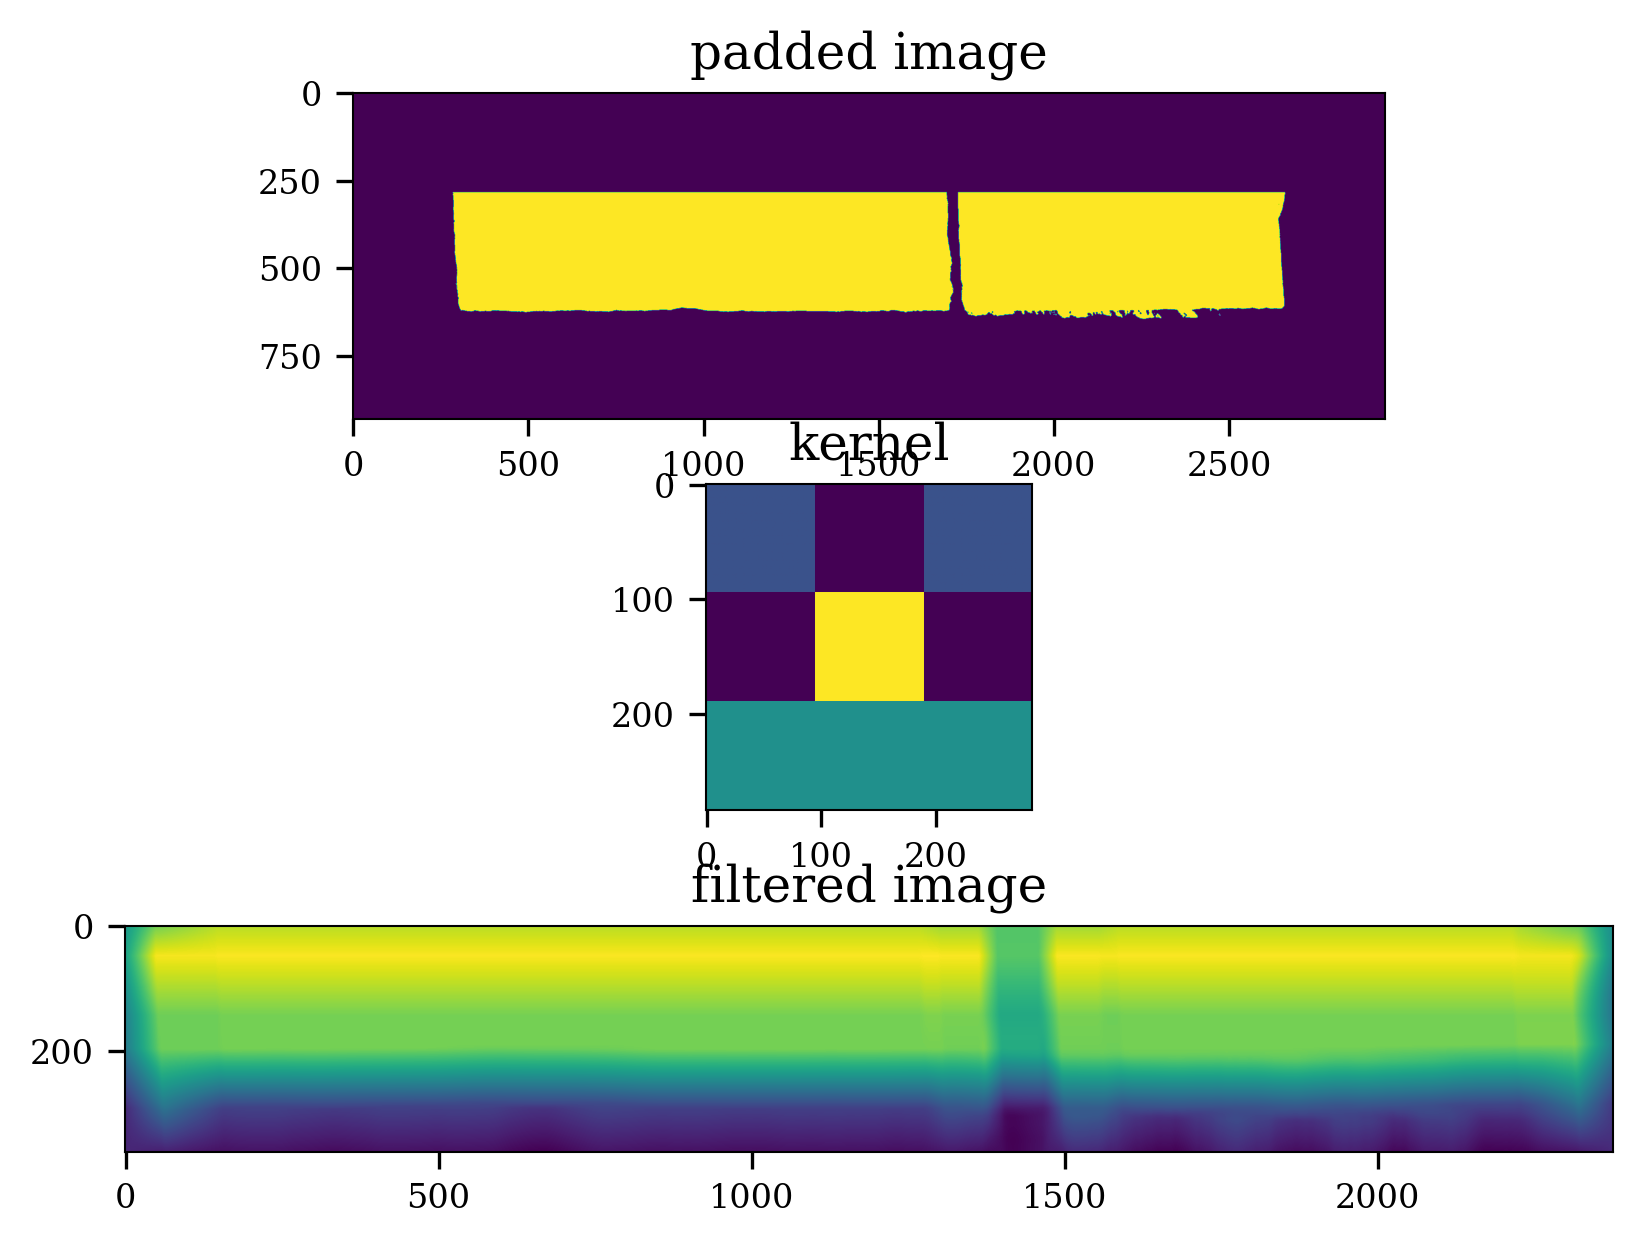

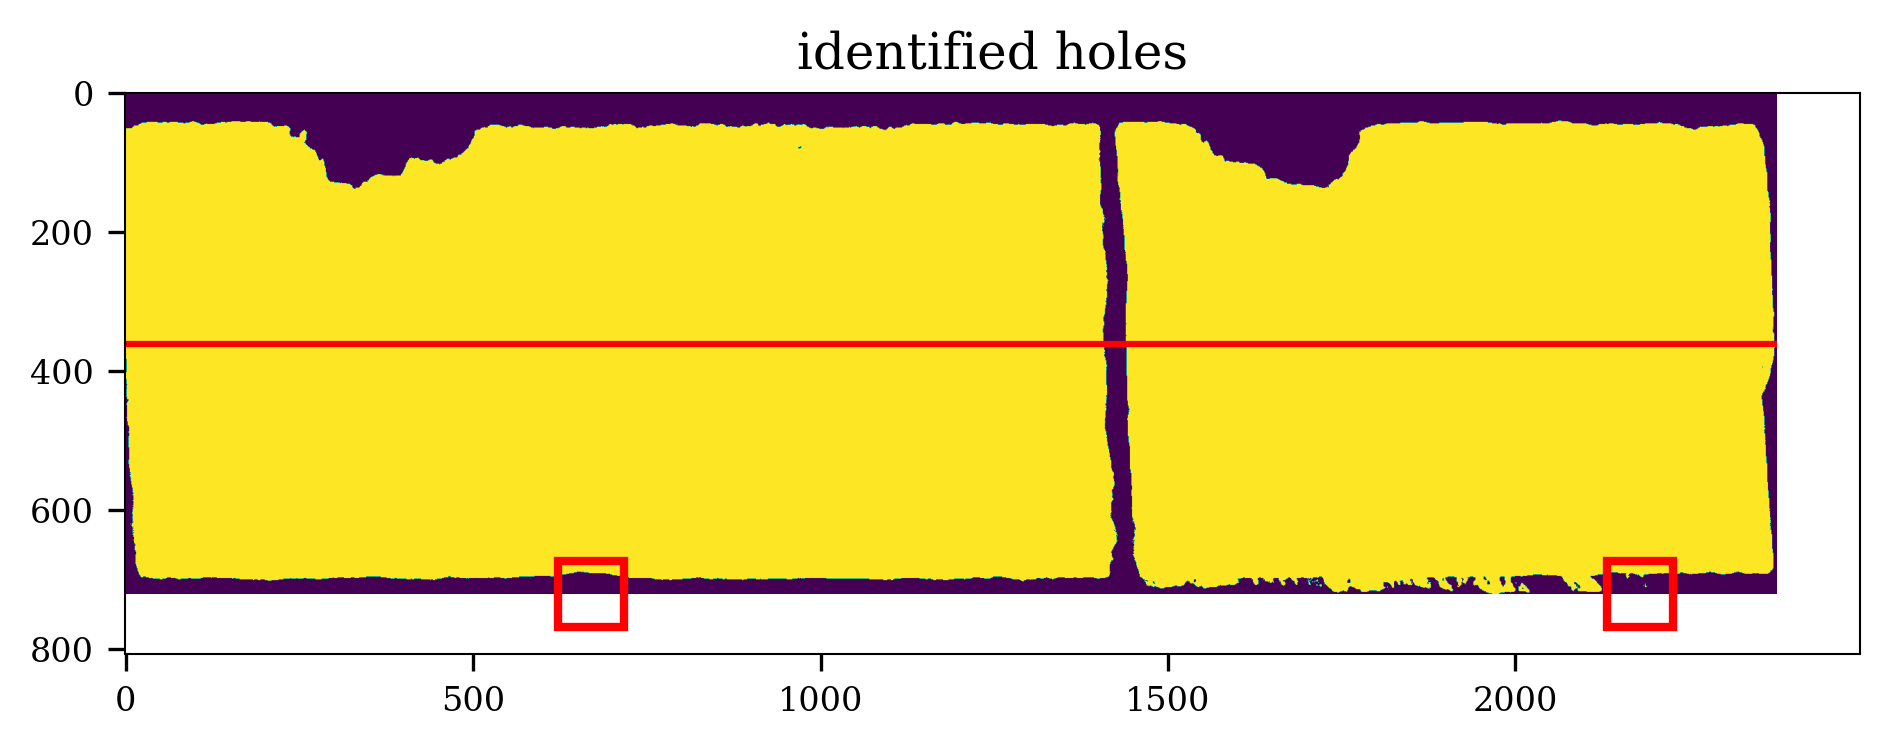

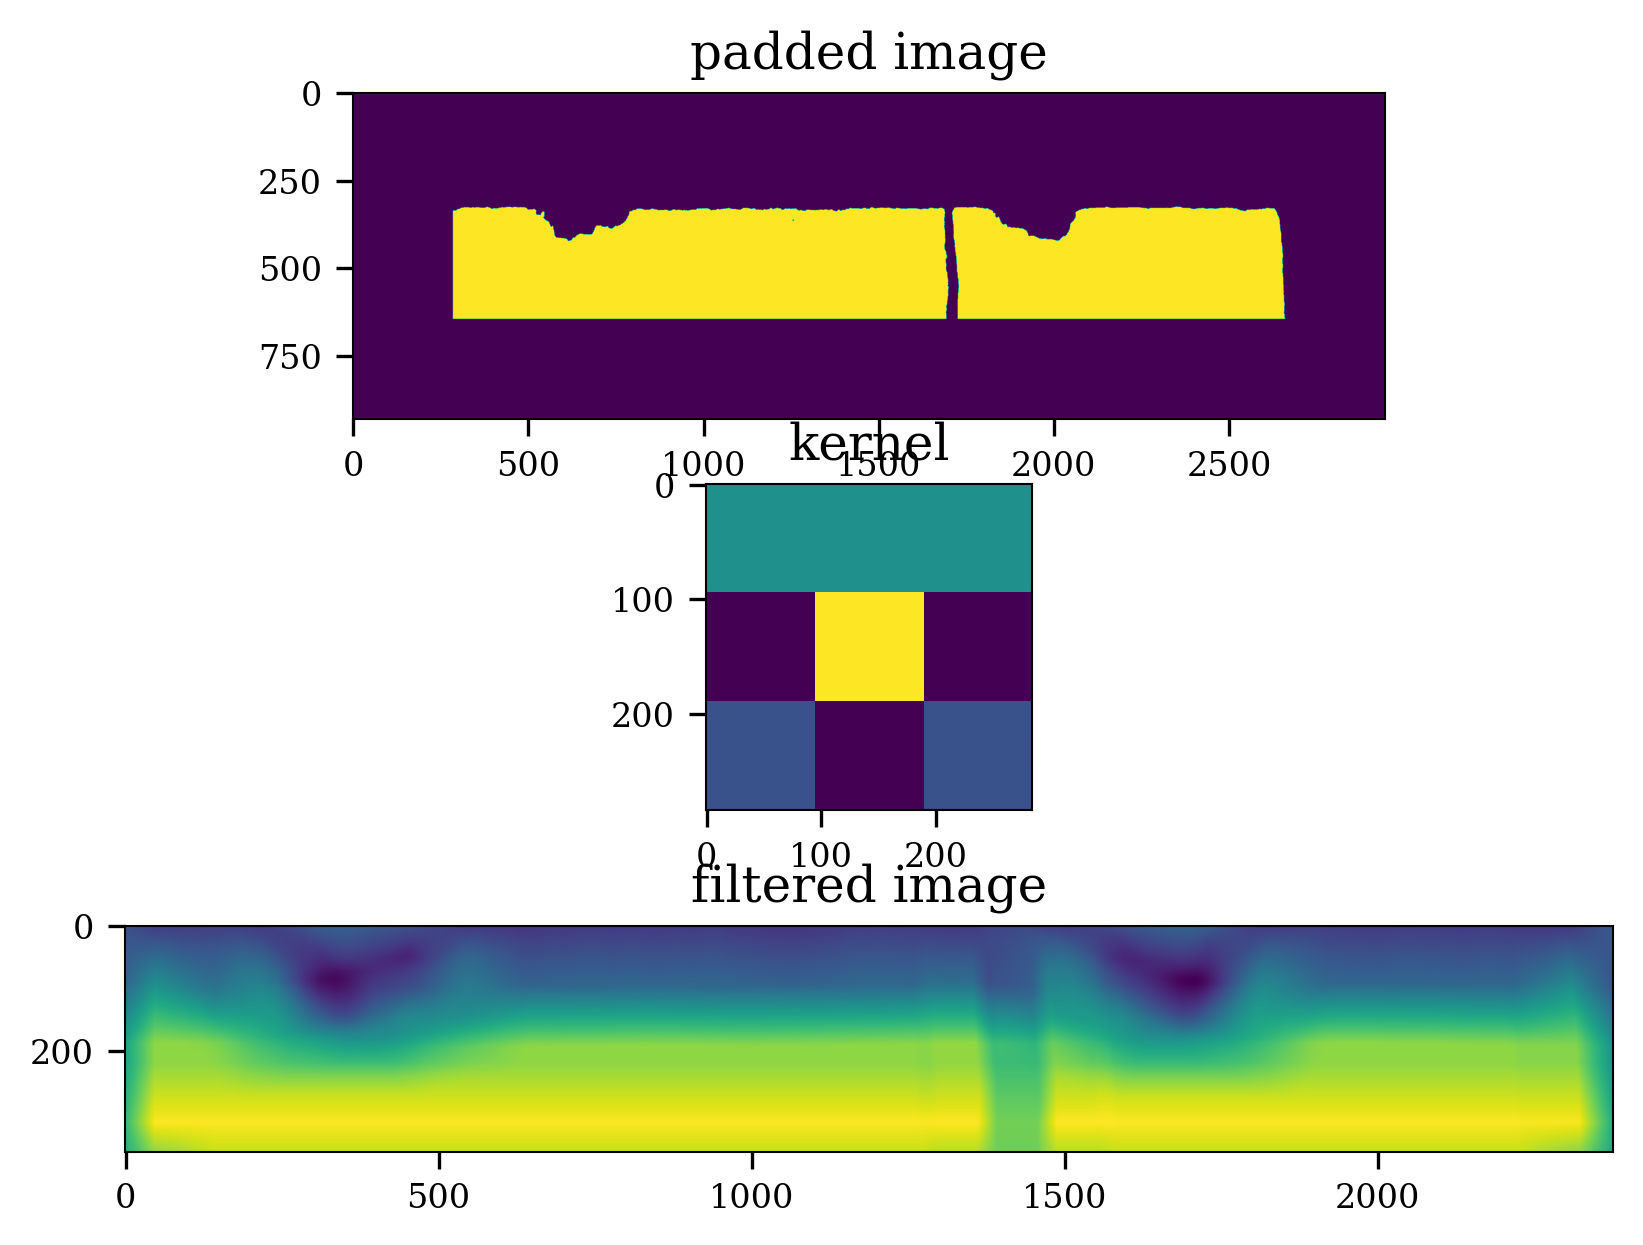

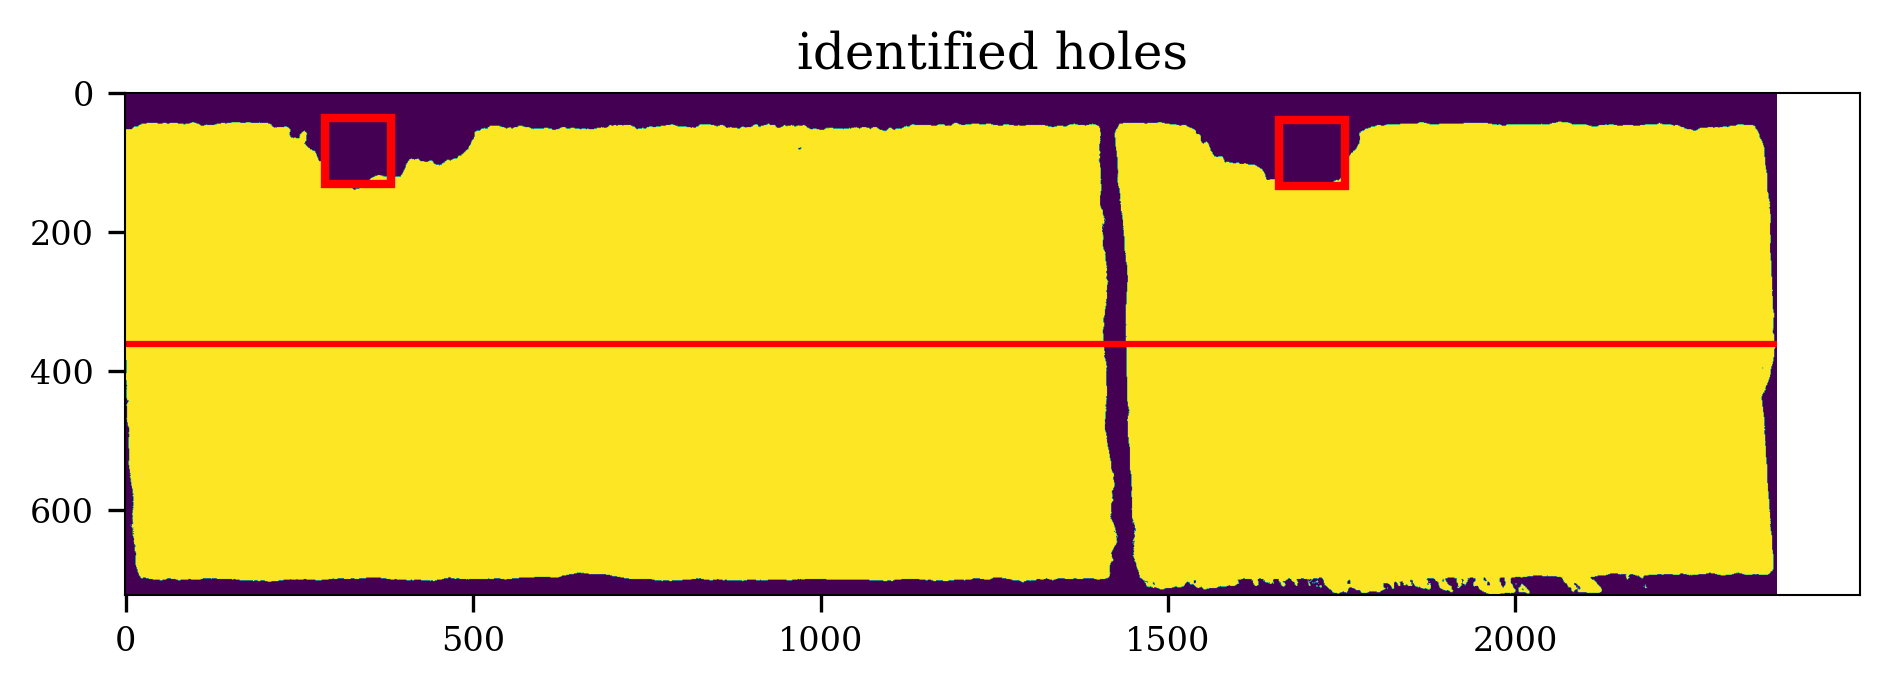

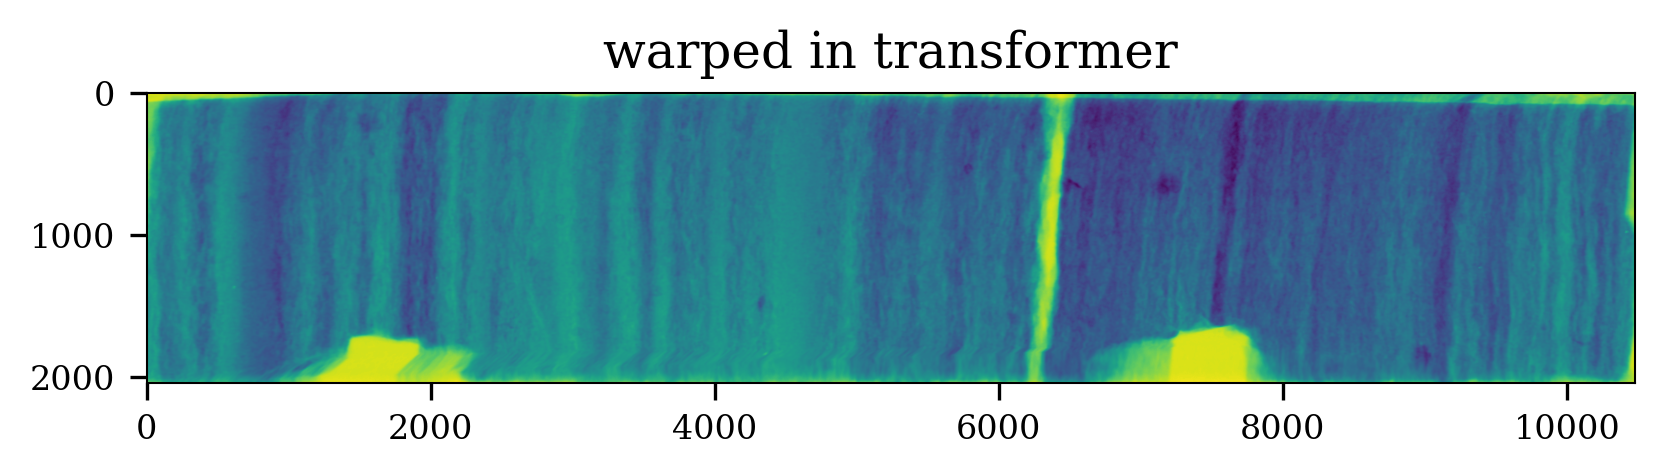

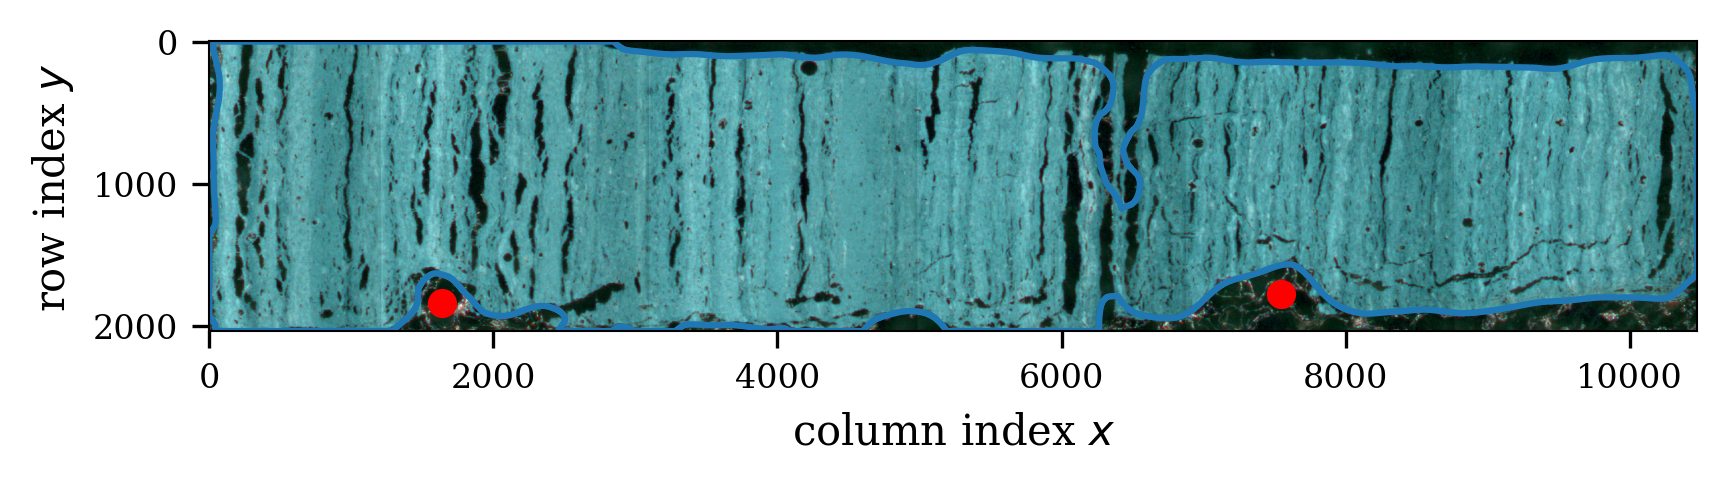

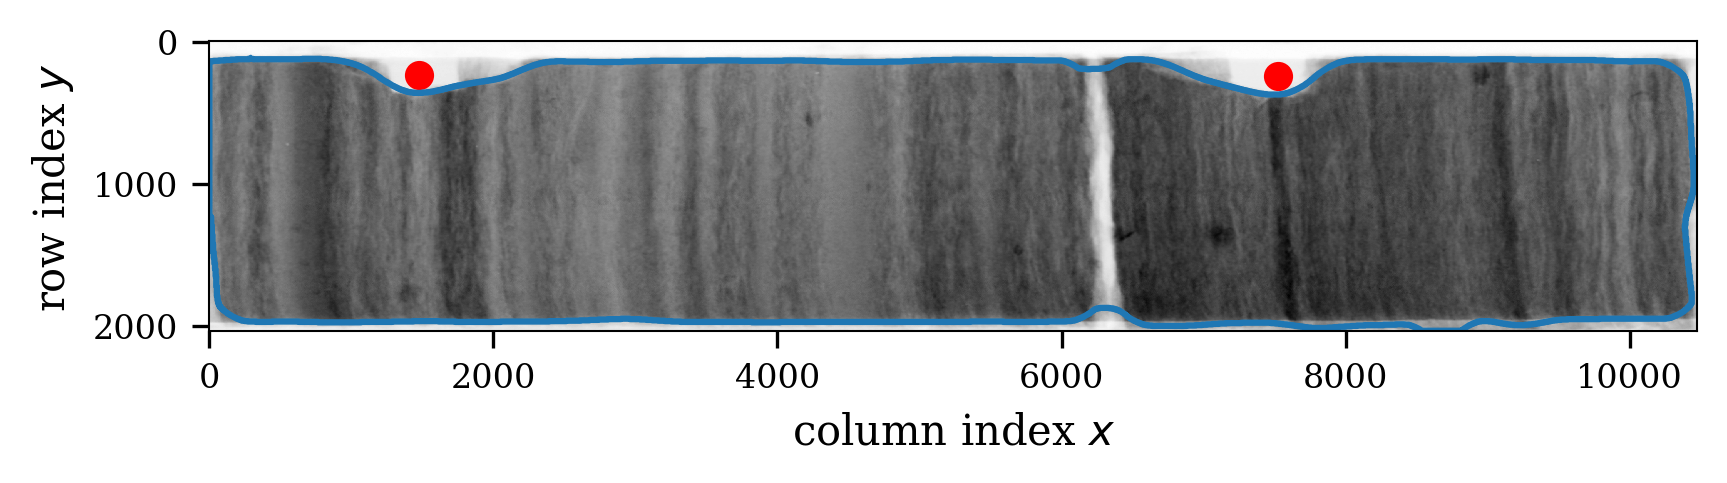

<Figure size 1920x1440 with 0 Axes>

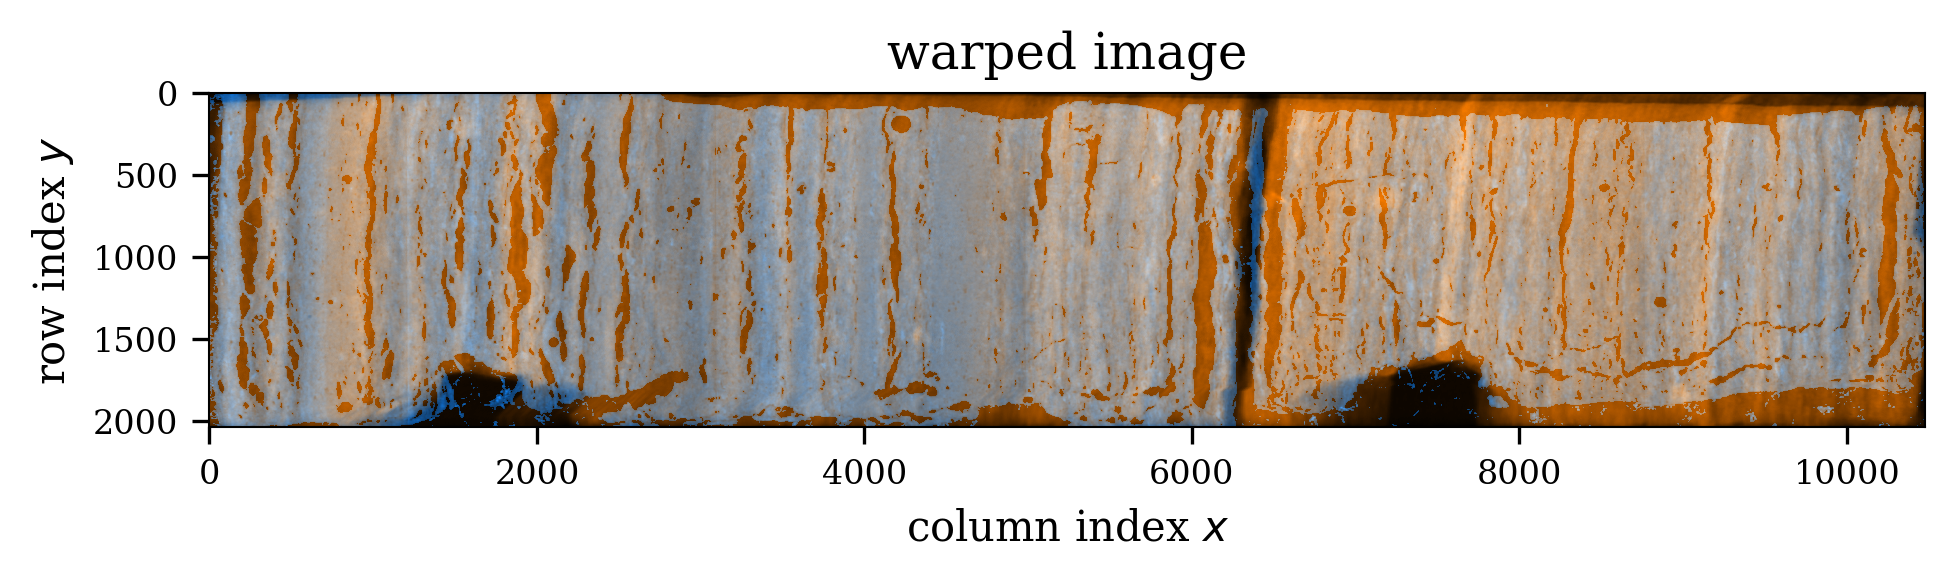

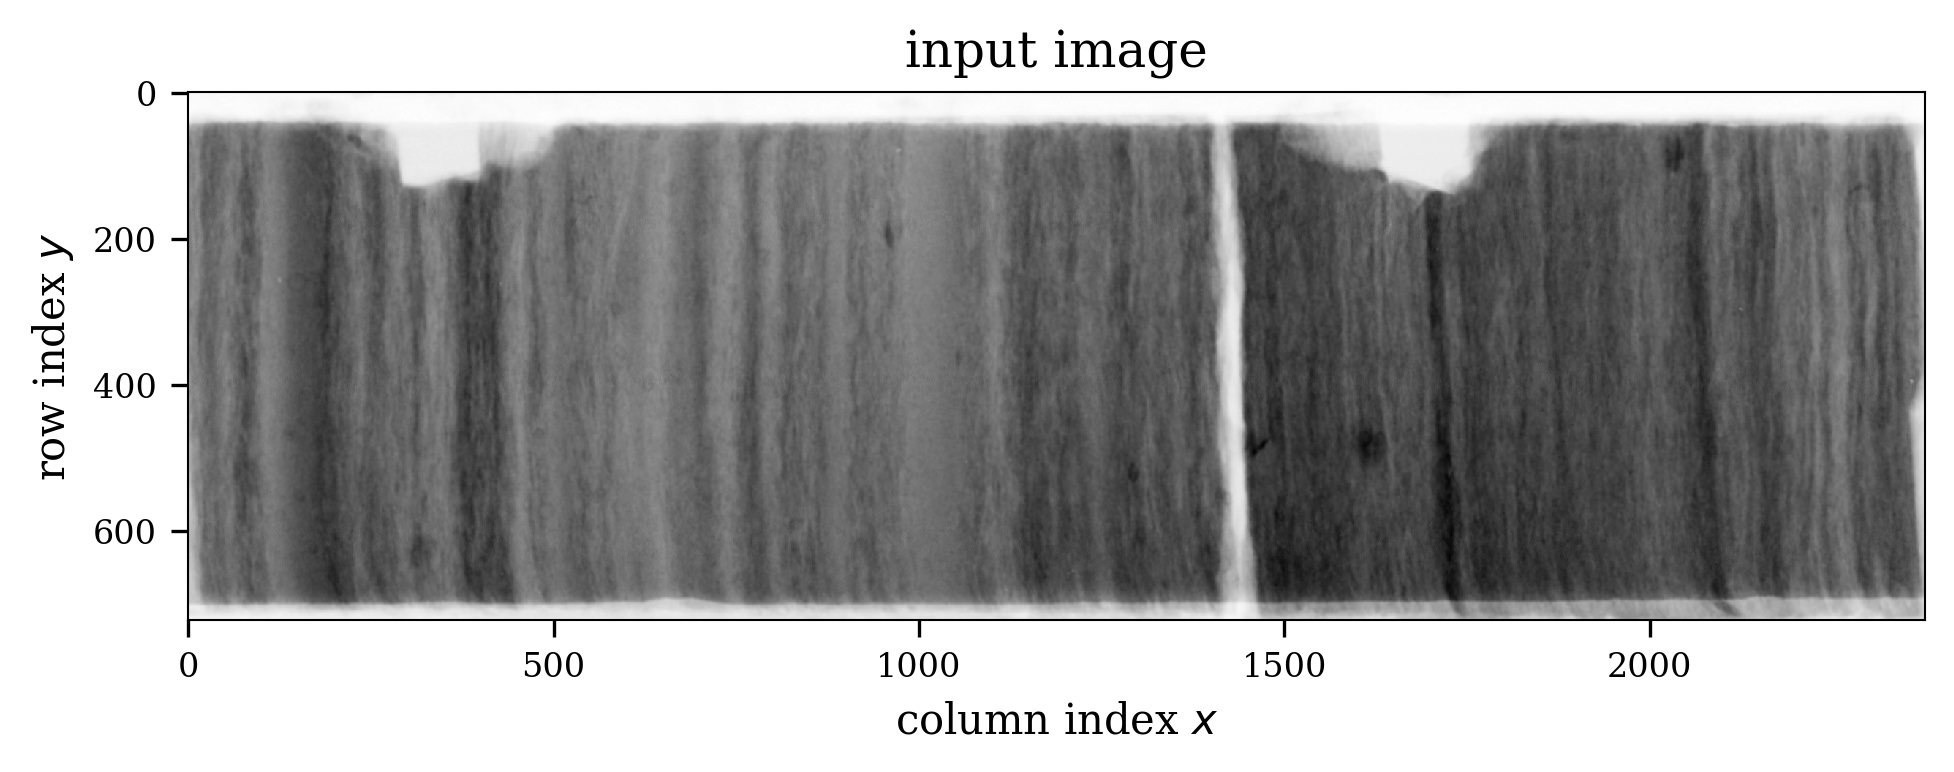

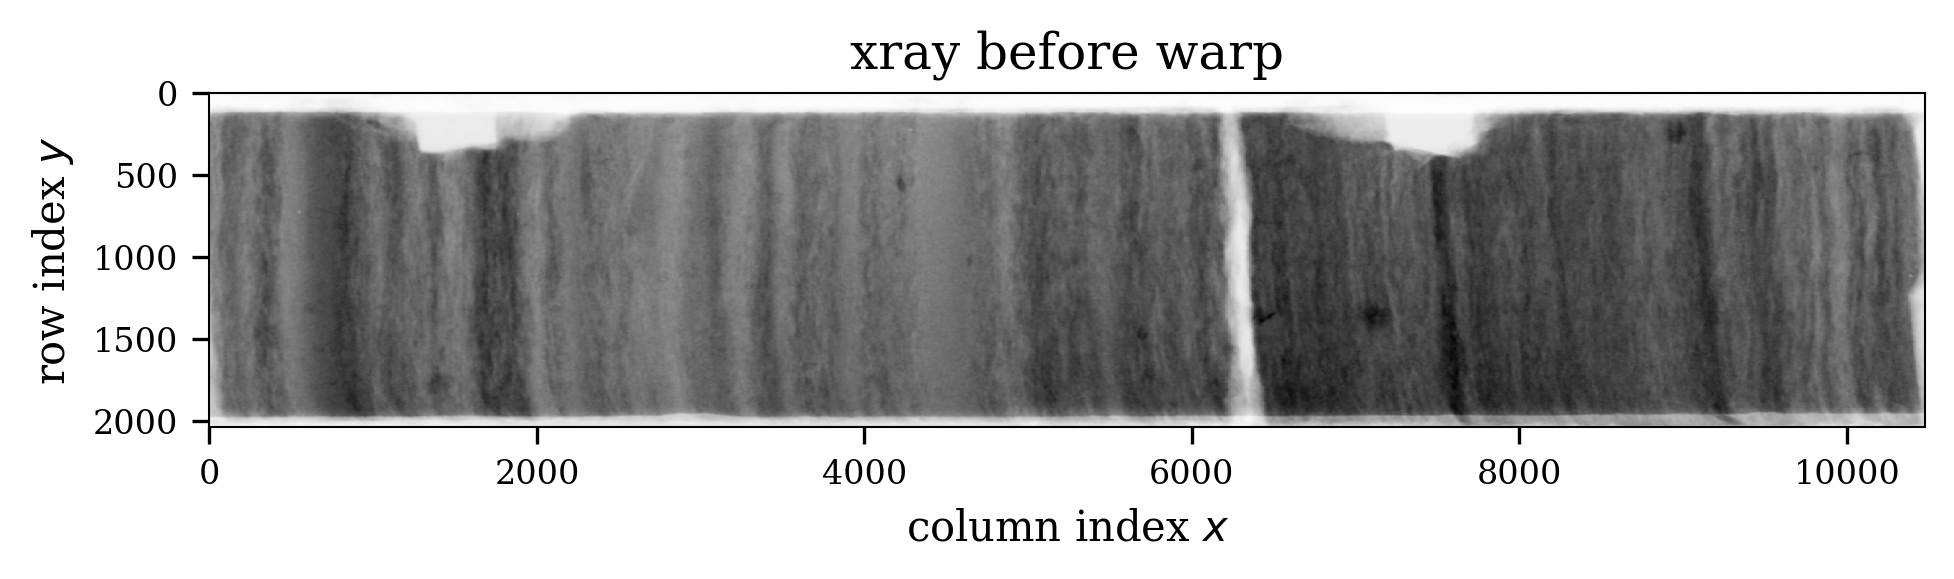

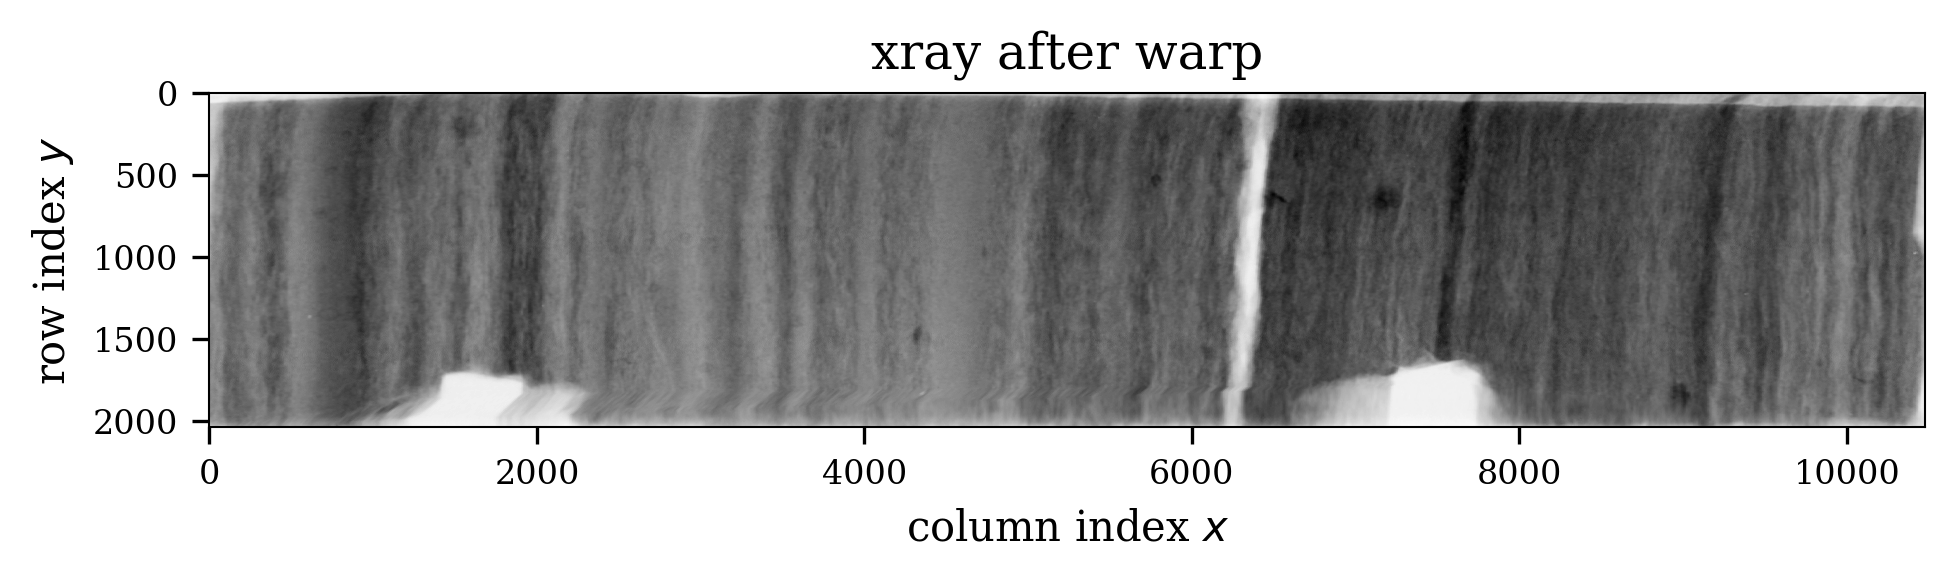

In [14]:
project.set_punchholes(plts=True)
project.require_xray_transform(plts=True)
project.add_xray(plts=True)

This is what the X-ray channel looks like compared to the photo

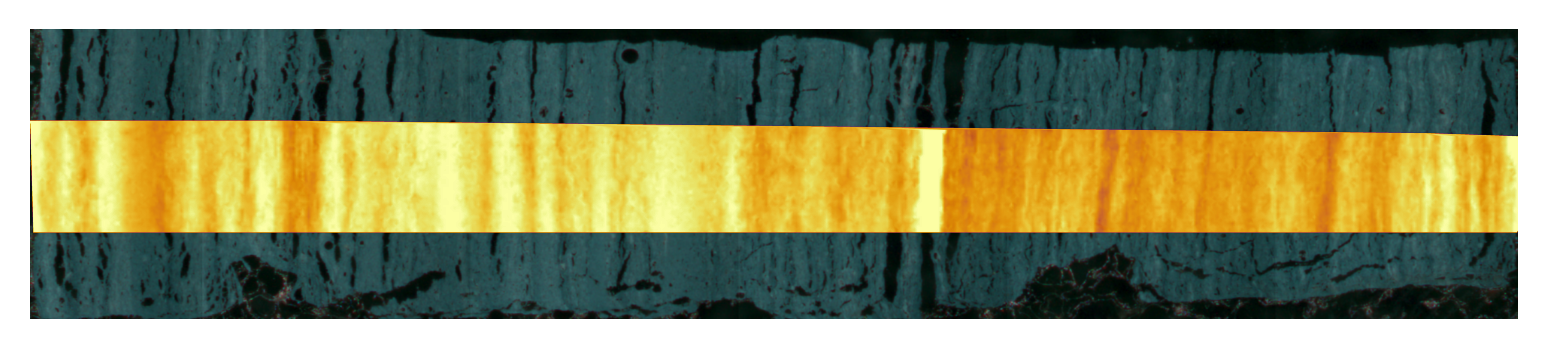

In [15]:
project.plot_comp('xray', plot_on_background=True)

## Save
Since we will need the MSI object with all the information we added in the next chapter, let's save it. The data_object is the only attribute of the project classes that will not be saved by default because it may not contain relevant additional information or some of the processing steps may not be desirable to save and would override a clean safe.

In [16]:
project.data_object.save(tag='with_images')